In [1]:
import sys
sys.path.append("..")
from collections import Counter

from plotting_tools import * 

In [2]:
def load_person_data(person_filename):
    # Read person df
    df = pd.read_csv(person_filename, sep=',')
    # Get hh size per home id
    hh_sizes = df[['puid', 'age', 'home_id']].groupby('home_id').size().rename('hh_size')
    # Add hh_size column to df
    df = df[['puid', 'age', 'home_id']].merge(hh_sizes, on='home_id')
    # Add age group column
    df['age_group'] = df['age'].apply(lambda x: age_to_age_group(x))
    return df

In [ ]:
person_csv = 'persons.csv'
df = load_person_data(person_csv)

In [4]:
custom_cmap_blue = mcolors.LinearSegmentedColormap.from_list('custom_blue', [colors['White'], colors['Blue'], colors['Black']])
custom_cmap_purple = mcolors.LinearSegmentedColormap.from_list('custom_purple', [colors['White'], colors['Purple'], colors['Black']]) 
custom_cmap_teal = mcolors.LinearSegmentedColormap.from_list('custom_teal', [colors['White'], colors['Teal'], colors['Black']])     

C:\Users\bick_ju\AppData\Local\Temp\ipykernel_8304\3600726572.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9.049470229052332' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  age_group_dist.loc[index, 'percentage'] = 100 * row.counts / age_group_dist['counts'].sum()
C:\Users\bick_ju\AppData\Local\Temp\ipykernel_8304\3600726572.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


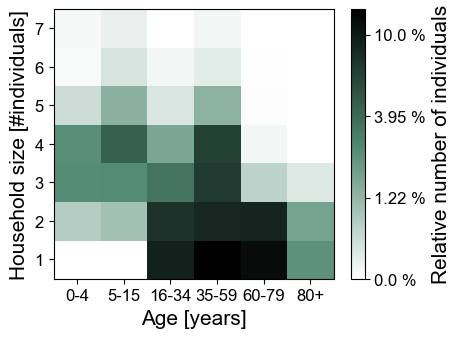

In [5]:
# Age group per household size
age_group_dist = df.groupby(['hh_size', 'age_group']).size().reset_index(name='counts')
# Add percentage column
age_group_dist['percentage'] = 0
for index, row in age_group_dist.iterrows():
    age_group_dist.loc[index, 'percentage'] = 100 * row.counts / age_group_dist['counts'].sum()

# Create one matrix for percentage values    
age_group_dict = {'0-4': 0, '5-15': 1, '16-34': 2, '35-59': 3, '60-79': 4, '80+': 5}
values_percentage = np.zeros((len(age_group_dist.hh_size.unique()), len(age_group_dict)))
# Fill matrices; Row is household size and column is age group
for size in age_group_dist.hh_size.unique():
    sub_df = age_group_dist[age_group_dist.hh_size == size]
    for index, row in sub_df.iterrows():
        values_percentage[size-1, age_group_dict[row.age_group]] = row.percentage

# Plot percentage values   
fig = plt.figure(figsize = (5, 3.5))
ax = fig.add_axes([0.16, 0.15, 0.7, 0.77])
vmin, vmax = np.min(values_percentage), np.max(values_percentage)
norm = Log1pNorm(vmin=vmin, vmax=vmax)   
im = ax.imshow(values_percentage, cmap=custom_cmap_teal, norm=norm, origin='lower', aspect='auto')
ax.set_xticks(np.arange(len(age_group_dict)))
ax.set_xticklabels(age_group_dict.keys())
ax.set_yticks(np.arange(len(age_group_dist.hh_size.unique())))
ax.set_yticklabels(age_group_dist.hh_size.unique())
ax.set_ylabel('Household size [#individuals]')
ax.set_xlabel('Age [years]')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Relative number of individuals')
n_ticks = 4
normed_positions = np.linspace(0, norm(10), n_ticks)
tick_values = [np.round(norm.inverse(p), 2) for p in normed_positions]
cbar.set_ticks(tick_values)
cbar.set_ticklabels([f"{tick} %" for tick in tick_values])
plt.tight_layout()
plt.show()
fig.savefig('hh_size_age_dist_heatmap_percentage' + '.png', dpi=dpi)

Total number of 2-Person households:  217520.0


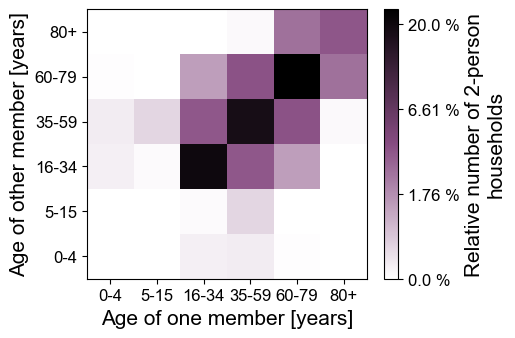

In [6]:
# Get only 2-person households
df_two_hh = df[df['hh_size'] == 2]
# Counts age group pairs
pair_counts = Counter()
num_households = 0.
for _, group in df_two_hh.groupby('home_id'):#
    concrete_ages = list(group['age'])
    ages = list(group['age_group'])
    pair = (ages[0], ages[1])
    pair_counts[pair] += 1.
    num_households += 1.

print("Total number of 2-Person households: ", num_households)
# Create heatmap matrix with percentages
values = np.zeros((len(age_group_dict), len(age_group_dict)))
for pair in pair_counts:
    values[age_group_dict[pair[0]], age_group_dict[pair[1]]] = 100.*(float(pair_counts[pair])/float(num_households))
    values[age_group_dict[pair[1]], age_group_dict[pair[0]]] = 100.*(float(pair_counts[pair])/float(num_households))

postfix = "percentage"
cb_label = 'Relative number of 2-person\nhouseholds'

vmin, vmax = np.min(values), np.max(values)
norm = Log1pNorm(vmin=vmin, vmax=vmax)        
fig = plt.figure(figsize = (5, 3.5))
ax = fig.add_axes([0.16, 0.15, 0.7, 0.77])
im = ax.imshow(values, cmap=custom_cmap_purple, norm=norm, origin='lower', aspect='auto')
ax.set_xticks(np.arange(len(age_group_dict)))
ax.set_xticklabels(age_group_dict.keys())
ax.set_yticks(np.arange(len(age_group_dict)))
ax.set_yticklabels(age_group_dict.keys())
ax.set_ylabel('Age of other member [years]')
ax.set_xlabel('Age of one member [years]')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(cb_label)
n_ticks = 4
normed_positions = np.linspace(0, norm(20), n_ticks)
ticks = [np.round(norm.inverse(p), 2) for p in normed_positions]
tick_labels = [f"{tick} %" for tick in ticks]
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)
plt.show()
fig.savefig('heatmap_2_hh_agegroups_' + postfix + '.png', dpi=dpi)

Total number of 3-Person households:  83064
Total number of 3-Person households having youngest member of age 0-4:  36685.0


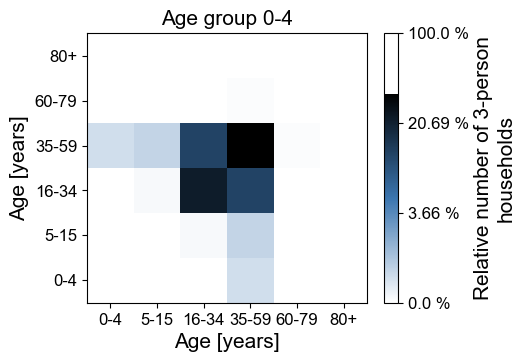

Total number of 3-Person households having youngest member of age 5-15:  26967.0


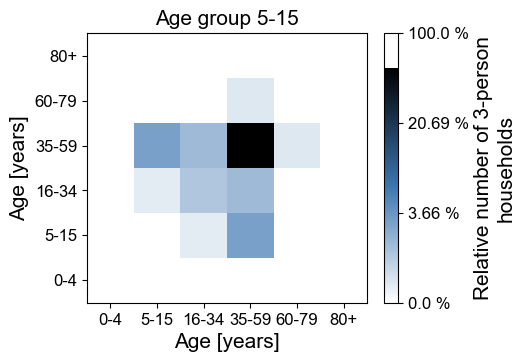

Total number of 3-Person households having youngest member of age 16-34:  17036.0


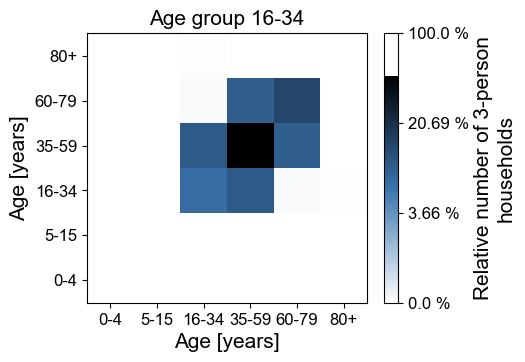

Total number of 3-Person households having youngest member of age 35-59:  1025.0


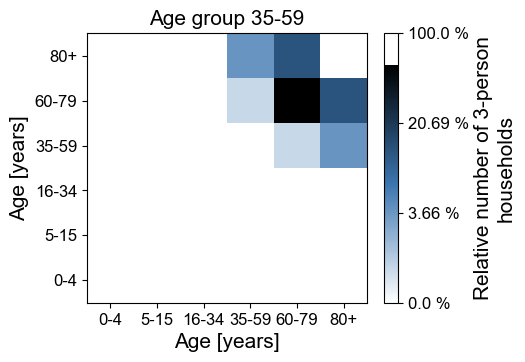

Total number of 3-Person households having youngest member of age 60-79:  57.0


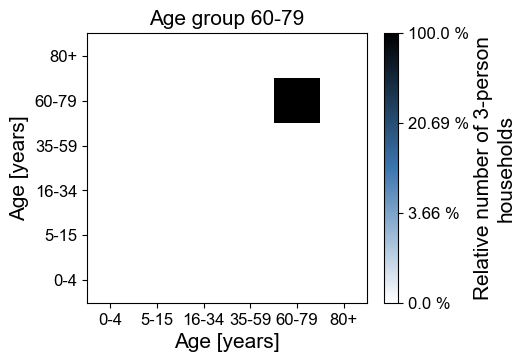

Total number of 3-Person households having youngest member of age 80+:  1294.0


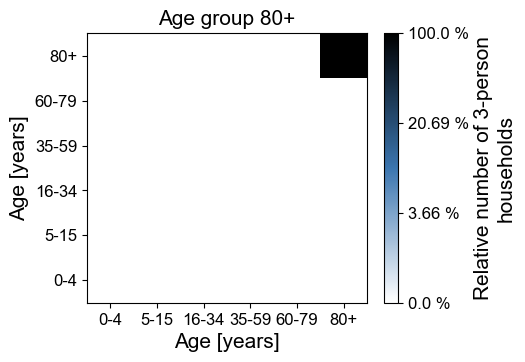

C:\Users\bick_ju\AppData\Local\Temp\ipykernel_8304\3548157675.py:54: UserWarning: Adding colorbar to a different Figure <Figure size 500x350 with 2 Axes> than <Figure size 500x350 with 2 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(im, ax=ax)


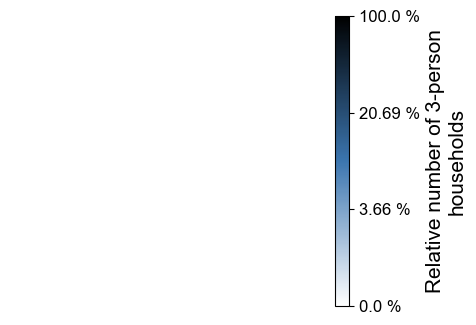

In [10]:
# Get only 3-person households
df_three_hh = df[df['hh_size'] == 3]
total_numer_of_3_pp_hh = len(df_three_hh.home_id.unique())
print(f"Total number of 3-Person households: ", total_numer_of_3_pp_hh)
for ag in age_group_dict.keys():
    # Counts age group pairs
    pair_counts = Counter()
    num_households = 0.
    for _, group in df_three_hh.groupby('home_id'):
        # If age group is in househould get pair of the other hh members age groups
        if ag in list(group.age_group):
            ages = list(group.age_group)
            ages.remove(ag)
            # Check if member is the youngest with youngest meaning <=
            if(age_group_dict[ag] <= age_group_dict[ages[0]] and age_group_dict[ag] <= age_group_dict[ages[1]]):
                pair = (ages[0], ages[1])
                pair_counts[pair] += 1.
                num_households += 1
            else:
                continue

    print(f"Total number of 3-Person households having youngest member of age {ag}: ", num_households)
    # Create heatmap matrices with percentages
    values_percentages = np.zeros((len(age_group_dict), len(age_group_dict)))
    for pair in pair_counts:
        values_percentages[age_group_dict[pair[0]], age_group_dict[pair[1]]] = 100.*(float(pair_counts[pair])/float(num_households))
        values_percentages[age_group_dict[pair[1]], age_group_dict[pair[0]]] = 100.*(float(pair_counts[pair])/float(num_households))
                    
    # Absolute values
    fig = plt.figure(figsize = (5, 3.5))
    ax = fig.add_axes([0.16, 0.15, 0.7, 0.77])
    vmin, vmax = np.min(values_percentages), np.max(values_percentages)
    norm = Log1pNorm(vmin=vmin, vmax=vmax)   
    # Use log scale for cmap
    im = ax.imshow(values_percentages, cmap=custom_cmap_blue, norm=norm, origin='lower', aspect='auto')
    ax.set_title(f'Age group {ag}')
    ax.set_xticks(np.arange(len(age_group_dict)))
    ax.set_xticklabels(age_group_dict.keys())
    ax.set_yticks(np.arange(len(age_group_dict)))
    ax.set_yticklabels(age_group_dict.keys())
    ax.set_ylabel('Age [years]')
    ax.set_xlabel('Age [years]')
    cbar = fig.colorbar(im, ax=ax)
    n_ticks = 4
    normed_positions = np.linspace(0, norm(100), n_ticks)
    ticks = [np.round(norm.inverse(p), 2) for p in normed_positions]
    tick_labels = [f"{tick} %" for tick in ticks]
    cbar.set_ticks(ticks)
    cbar.set_ticklabels(tick_labels)
    cbar.set_label(f'Relative number of 3-person\nhouseholds')
    plt.show()
    fig.savefig(f'heatmap_3_hh_agegroups_percentage_{ag}_youngest.png', dpi=dpi)
fig, ax = plt.subplots(figsize = (5, 3.5))
cbar = fig.colorbar(im, ax=ax)
n_ticks = 4
normed_positions = np.linspace(0, norm(100), n_ticks)
ticks = [np.round(norm.inverse(p), 2) for p in normed_positions]
tick_labels = [f"{tick} %" for tick in ticks]
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)
cbar.set_label(f'Relative number of 3-person\nhouseholds')
ax.set_axis_off()
plt.tight_layout()
plt.show()
fig.savefig(f'heatmap_3_hh_agegroups_percentage_youngest_cbar.png', dpi=dpi)